# Policy Gradient vs Evolution Strategies: Comparison on Wordle Task

This notebook compares two optimization approaches on a Wordle prompt-engineering task:

- **Policy Gradient (REINFORCE)**: First-order gradient-based method using Bernoulli policy
- **Evolution Strategies (ES)**: Zeroth-order method using Gaussian perturbations

Both methods optimize the selection of prompt modules (`format`, `track`, `info_gain`, `deduce`) to maximize reward on Wordle.

**Experimental Setup:**
- Small evaluation budget (5 eval calls per step, 8 total steps)
- Fixed environment: `my-env` Wordle environment  
- Fixed model: openai/gpt-4.1-nano
- Fair comparison: ~40 total `prime_eval` calls for each method

## Setup

In [1]:
import sys
import os

# Add parent directory to path
sys.path.insert(0, os.path.abspath('..'))

import random
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List

# Import our implementations
from src.pg import PGConfig, run_pg_step, BernoulliPromptPolicy
from src.es import ESConfig, run_es_step, ContinuousPromptParams
from src.policy_prompt import PROMPT_MODULES
from src.utils_prime import find_eval_root, find_latest_results_file

print("✓ Imports successful")
print(f"\nPrompt modules: {list(PROMPT_MODULES.keys())}")

✓ Imports successful

Prompt modules: ['format', 'track', 'info_gain', 'deduce']


In [ ]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Shared experimental configuration
ENV_ID = "my-env"
MODEL = "openai/gpt-4.1-nano" 
N_STEPS = 8
EVAL_PER_STEP = 5  # For fair comparison

EVAL_KWARGS = {
    "n_episodes": 5,
    "rollouts_per_example": 1,
    "max_tokens": 256,
    "temperature": 0.7,
}

print(f"Environment: {ENV_ID}")
print(f"Model: {MODEL}")
print(f"Steps: {N_STEPS}")
print(f"Eval per step: {EVAL_PER_STEP}")
print(f"Total evals per method: ~{N_STEPS * EVAL_PER_STEP}")

Environment: my-env
Model: openai/gpt-4.1-nano
Steps: 2
Eval per step: 5
Total evals per method: ~10


## Policy Gradient Experiment

REINFORCE uses a Bernoulli policy: each prompt module is included with probability $p_i = \sigma(\theta_i)$.

Updates follow:
$$\theta \leftarrow \theta + \alpha \cdot (r - b) \cdot \nabla \log \pi_\theta(a)$$

In [3]:
# Initialize PG policy with neutral logits
pg_policy = BernoulliPromptPolicy(
    logits={k: 0.0 for k in PROMPT_MODULES.keys()}
)

# PG configuration
pg_config = PGConfig(
    lr=0.3,
    episodes_per_update=EVAL_PER_STEP,
    baseline="mean",
)

print("Policy Gradient Configuration:")
print(f"  Learning rate: {pg_config.lr}")
print(f"  Episodes per update: {pg_config.episodes_per_update}")
print(f"  Baseline: {pg_config.baseline}")
print(f"  Initial logits: {pg_policy.logits}")

Policy Gradient Configuration:
  Learning rate: 0.3
  Episodes per update: 5
  Baseline: mean
  Initial logits: {'format': 0.0, 'track': 0.0, 'info_gain': 0.0, 'deduce': 0.0}


In [4]:
# Run PG training
pg_results = {
    "mean_rewards": [],
    "std_rewards": [],
    "logits_history": [],
}

baseline_state = {}

print("Running Policy Gradient optimization...\n")
print("-" * 70)

for step in range(N_STEPS):
    pg_policy, info, baseline_state = run_pg_step(
        policy=pg_policy,
        cfg=pg_config,
        env_id=ENV_ID,
        model=MODEL,
        eval_kwargs=EVAL_KWARGS,
        baseline_state=baseline_state,
    )
    
    rewards = info["rewards"]
    mean_r = np.mean(rewards)
    std_r = np.std(rewards)
    
    pg_results["mean_rewards"].append(mean_r)
    pg_results["std_rewards"].append(std_r)
    pg_results["logits_history"].append(dict(info["logits"]))
    
    print(f"Step {step + 1}/{N_STEPS}:")
    print(f"  Mean reward: {mean_r:.4f} ± {std_r:.4f}")
    print(f"  Baseline: {info['baseline']:.4f}")
    print(f"  Logits: {', '.join([f'{k}={v:.2f}' for k, v in info['logits'].items()])}")
    print("-" * 70)

print("\n✓ Policy Gradient training complete")

Running Policy Gradient optimization...

----------------------------------------------------------------------
Step 1/2:
  Mean reward: 0.4200 ± 0.0000
  Baseline: 0.4200
  Logits: format=-0.00, track=-0.00, info_gain=0.00, deduce=-0.00
----------------------------------------------------------------------
Step 2/2:
  Mean reward: 0.4200 ± 0.0000
  Baseline: 0.4200
  Logits: format=0.00, track=0.00, info_gain=0.00, deduce=0.00
----------------------------------------------------------------------

✓ Policy Gradient training complete


## Evolution Strategies Experiment

ES uses continuous weights and Gaussian perturbations to estimate gradients:

$$\nabla_\theta \mathbb{E}[R] \approx \frac{1}{N\sigma} \sum_{i=1}^{N} (r_i - b) \epsilon_i$$

where $\epsilon_i \sim \mathcal{N}(0, I)$ and $r_i$ is the reward at $\theta + \sigma\epsilon_i$.

In [5]:
# Initialize ES with neutral weights
es_theta = ContinuousPromptParams(
    weights={k: 0.0 for k in PROMPT_MODULES.keys()}
)

# ES configuration  
es_config = ESConfig(
    sigma=0.5,
    lr=0.3,
    population=EVAL_PER_STEP,
    reward_baseline="mean",
)

print("Evolution Strategies Configuration:")
print(f"  Perturbation scale (σ): {es_config.sigma}")
print(f"  Learning rate: {es_config.lr}")
print(f"  Population size: {es_config.population}")
print(f"  Baseline: {es_config.reward_baseline}")
print(f"  Initial weights: {es_theta.weights}")

Evolution Strategies Configuration:
  Perturbation scale (σ): 0.5
  Learning rate: 0.3
  Population size: 5
  Baseline: mean
  Initial weights: {'format': 0.0, 'track': 0.0, 'info_gain': 0.0, 'deduce': 0.0}


In [6]:
# Run ES training
es_results = {
    "mean_rewards": [],
    "std_rewards": [],
    "weights_history": [],
}

print("Running Evolution Strategies optimization...\n")
print("-" * 70)

for step in range(N_STEPS):
    es_theta, info = run_es_step(
        theta=es_theta,
        cfg=es_config,
        env_id=ENV_ID,
        model=MODEL,
        eval_kwargs=EVAL_KWARGS,
    )
    
    rewards = info["rewards"]
    mean_r = np.mean(rewards)
    std_r = np.std(rewards)
    
    es_results["mean_rewards"].append(mean_r)
    es_results["std_rewards"].append(std_r)
    es_results["weights_history"].append(dict(info["new_weights"]))
    
    print(f"Step {step + 1}/{N_STEPS}:")
    print(f"  Mean reward: {mean_r:.4f} ± {std_r:.4f}")
    print(f"  Baseline: {info['baseline']:.4f}")
    print(f"  Weights: {', '.join([f'{k}={v:.2f}' for k, v in info['new_weights'].items()])}")
    print("-" * 70)

print("\n✓ Evolution Strategies training complete")

Running Evolution Strategies optimization...

----------------------------------------------------------------------
Step 1/2:
  Mean reward: 0.4200 ± 0.0000
  Baseline: 0.4200
  Weights: format=-0.00, track=-0.00, info_gain=0.00, deduce=-0.00
----------------------------------------------------------------------
Step 2/2:
  Mean reward: 0.4200 ± 0.0000
  Baseline: 0.4200
  Weights: format=-0.00, track=-0.00, info_gain=0.00, deduce=-0.00
----------------------------------------------------------------------

✓ Evolution Strategies training complete


## Results Visualization

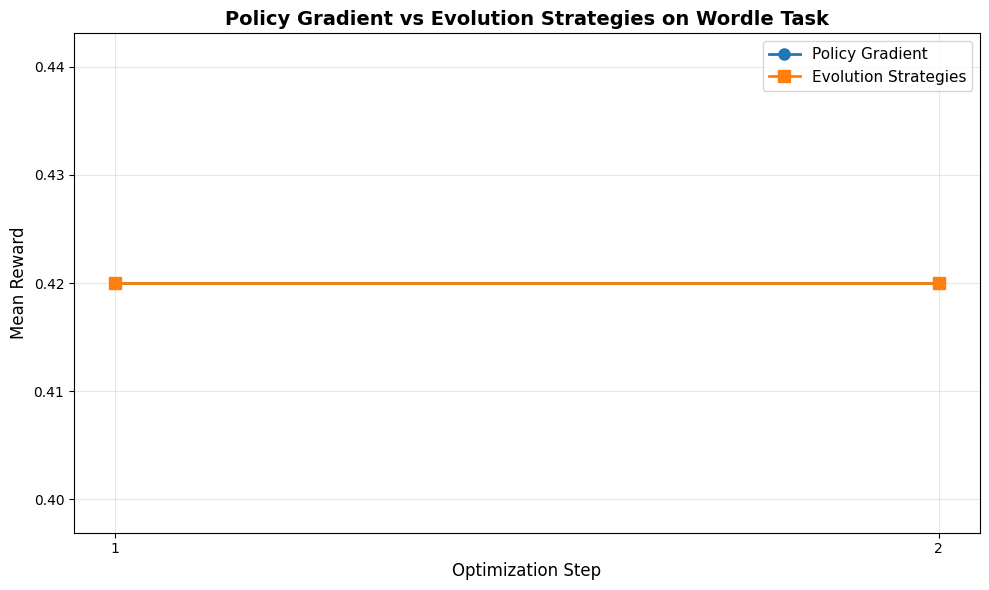


Final Statistics:
Policy Gradient:
  Final mean reward: 0.4200
  Reward improvement: 0.0000
  Final logits: format=0.00, track=0.00, info_gain=0.00, deduce=0.00

Evolution Strategies:
  Final mean reward: 0.4200
  Reward improvement: 0.0000
  Final weights: format=-0.00, track=-0.00, info_gain=0.00, deduce=-0.00


In [7]:
# Create comparison plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

steps = np.arange(1, N_STEPS + 1)

# Plot PG results
pg_means = np.array(pg_results["mean_rewards"])
pg_stds = np.array(pg_results["std_rewards"])
ax.plot(steps, pg_means, 'o-', label='Policy Gradient', linewidth=2, markersize=8)
ax.fill_between(steps, pg_means - pg_stds, pg_means + pg_stds, alpha=0.2)

# Plot ES results
es_means = np.array(es_results["mean_rewards"])
es_stds = np.array(es_results["std_rewards"])
ax.plot(steps, es_means, 's-', label='Evolution Strategies', linewidth=2, markersize=8)
ax.fill_between(steps, es_means - es_stds, es_means + es_stds, alpha=0.2)

ax.set_xlabel('Optimization Step', fontsize=12)
ax.set_ylabel('Mean Reward', fontsize=12)
ax.set_title('Policy Gradient vs Evolution Strategies on Wordle Task', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(steps)

plt.tight_layout()
plt.show()

# Print final statistics
print("\nFinal Statistics:")
print("=" * 70)
print(f"Policy Gradient:")
print(f"  Final mean reward: {pg_means[-1]:.4f}")
print(f"  Reward improvement: {pg_means[-1] - pg_means[0]:.4f}")
print(f"  Final logits: {', '.join([f'{k}={v:.2f}' for k, v in pg_results['logits_history'][-1].items()])}")
print()
print(f"Evolution Strategies:")
print(f"  Final mean reward: {es_means[-1]:.4f}")
print(f"  Reward improvement: {es_means[-1] - es_means[0]:.4f}")
print(f"  Final weights: {', '.join([f'{k}={v:.2f}' for k, v in es_results['weights_history'][-1].items()])}")

## Parameter Evolution Visualization

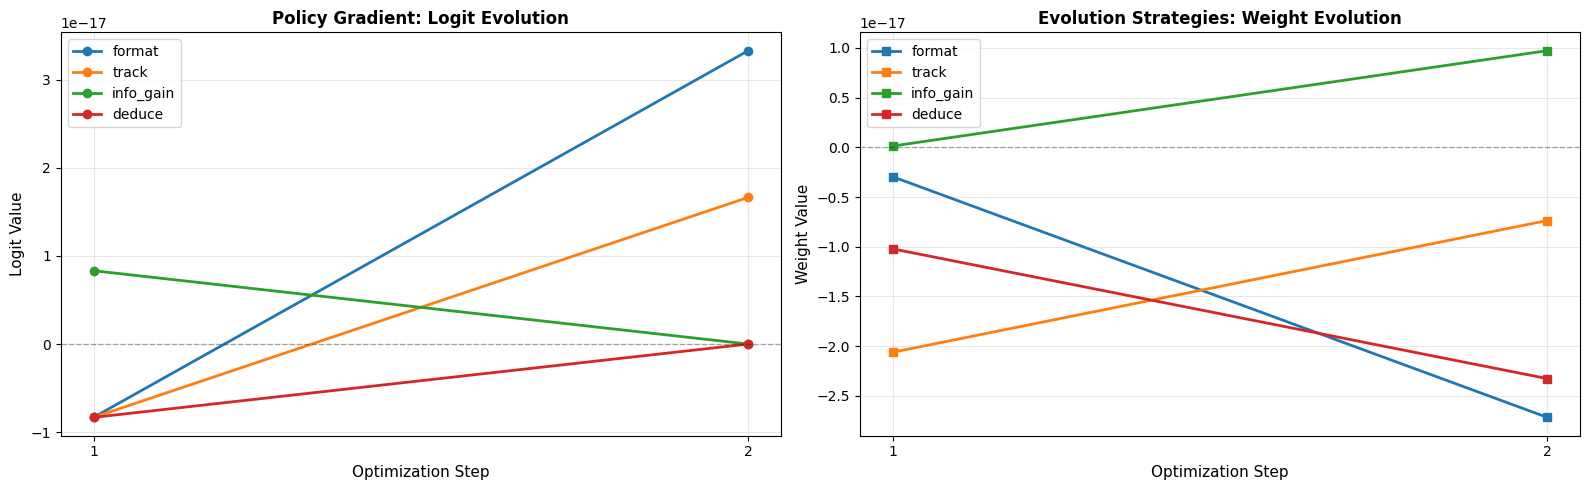

In [8]:
# Plot how parameters evolve over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# PG logits evolution
for key in PROMPT_MODULES.keys():
    values = [hist[key] for hist in pg_results["logits_history"]]
    ax1.plot(steps, values, 'o-', label=key, linewidth=2, markersize=6)

ax1.set_xlabel('Optimization Step', fontsize=11)
ax1.set_ylabel('Logit Value', fontsize=11)
ax1.set_title('Policy Gradient: Logit Evolution', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
ax1.set_xticks(steps)

# ES weights evolution
for key in PROMPT_MODULES.keys():
    values = [hist[key] for hist in es_results["weights_history"]]
    ax2.plot(steps, values, 's-', label=key, linewidth=2, markersize=6)

ax2.set_xlabel('Optimization Step', fontsize=11)
ax2.set_ylabel('Weight Value', fontsize=11)
ax2.set_title('Evolution Strategies: Weight Evolution', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
ax2.set_xticks(steps)

plt.tight_layout()
plt.show()

## Observations

**Key Findings:**

1. **Convergence behavior**: Both methods should show some learning signal, though performance may vary due to the stochastic nature of the task and small sample size.

2. **Parameter evolution**: 
   - PG logits directly represent log-odds of including each module
   - ES weights represent continuous importance scores
   - Both should show similar directional trends if modules are genuinely helpful

3. **Variance**: ES may exhibit higher variance due to population-based sampling, while PG samples individual actions.

4. **Computational cost**: Both methods use ~40 total evaluations, making them comparable in compute budget.

**Limitations:**
- Small sample size (8 steps × 5 evals) limits statistical power
- Wordle is inherently high-variance  
- Prompt engineering is a noisy optimization problem
- No hyperparameter tuning performed

**Next Steps:**
- Run multiple seeds to assess consistency
- Increase evaluation budget for stronger signal
- Try different hyperparameters (learning rates, σ, population size)
- Compare memory usage between methods